In [1]:

import numpy as np
from quspin.operators import hamiltonian
from quspin.operators import quantum_LinearOperator
from scipy.sparse.linalg import eigsh
# Import the GENERAL basis for spinless fermions
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
from quspin.operators import hamiltonian
from quspin.basis import spinless_fermion_basis_general
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def map_double_index_to_single(i, j, Lx, Ly):
    if i < 0 or i >= Lx or j < 0 or j >= Ly:
        raise ValueError("Indices out of bounds")
    """Map a double index (i, j) to a single index in a flattened LxL array."""
    return j * Lx + i

def map_single_index_to_double(index, Lx, Ly):

    """Map a single index in a flattened LxL array back to a double index (i, j)."""
    i = index % Lx
    j = index // Lx
    return i, j

def calculate_density(vector, N_sites, basis_full): 
    """
    Correctly calculates the particle density using the hamiltonian.expt_value() 
    method for a symmetry-reduced basis.
    """

    densities = np.zeros(N_sites, dtype=np.float64)


    print("Calculating densities using hamiltonian.expt_value()...")
    
    # Iterate over every *physical site* j
    
    for j in range(N_sites):
        # 3. Define the local density operator "n_j"
        # This is "n" acting on site j.
        op_list = [["n", [[1.0, j]]]]

        n_j_op = hamiltonian(op_list, [],
                            basis=basis_full,
                            check_symm=False,
                            check_herm=False, check_pcon=False, dtype=np.float64) # 'n' is hermitian

        # 5. Calculate the expectation value
        #    This computes <psi_k | n_j | psi_k>
        density_at_j = n_j_op.expt_value(vector)
        
        # Ensure the value is real
        densities[j] = np.real(density_at_j)
    return densities

def compute_chern_number(Lx, Ly, q, band_index, eigenvectors):
    '''
    eigenvectors must be a three-dimensional array with shape [Lx//q, Ly, components of eigenvector in q basis].
    '''
    # Normalize eigenvectors to avoid numerical issues
    eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=-1, keepdims=True)

    total_berry_flux = 0.0
    for i in range(Lx // q):
        for j in range(Ly):
            # Get the four eigenvectors for the plaquette corners
            uk = eigenvectors[i, j, band_index]
            uk_dx = eigenvectors[(i + 1) % (Lx // q), j, band_index]  # Neighbor in +kx
            uk_dy = eigenvectors[i, (j + 1) % Ly, band_index]  # Neighbor in +ky
            uk_dx_dy = eigenvectors[(i + 1) % (Lx // q), (j + 1) % Ly, band_index]

            # Compute Link Variables (inner products)
            link_0_dx = np.vdot(uk, uk_dx)
            link_dx_dxdy = np.vdot(uk_dx, uk_dx_dy)
            link_dxdy_dy = np.vdot(uk_dx_dy, uk_dy)
            link_dy_0 = np.vdot(uk_dy, uk)

            # Calculate Plaquette Flux (argument of the product of links)
            plaquette_flux = np.angle(link_0_dx * link_dx_dxdy * link_dxdy_dy * link_dy_0)
            total_berry_flux += plaquette_flux

    # Sum and Normalize
    chern_number = total_berry_flux / (2 * np.pi)
    
    # Round to nearest integer to avoid numerical errors
    return np.round(chern_number)


In [3]:

# QuSpin handles the fermionic signs internally.
def build_fermion_basis_with_translations(Lx, Ly, q, kx_prime_sector,ky_sector,  Nf):
    """
    Build a spinless fermion basis on a 2D Lx x Ly lattice with translation symmetries:
    """
    # Create 1D site-index array
    N=Lx * Ly
    sites = np.arange(N, dtype=np.int32)

    # Get (x,y) coordinates from 1D index (row-major mapping: s = x + y*Lx)
    x , y = map_single_index_to_double(sites, Lx, Ly)

    # Map 1: T_y -> (x, (y+1) % Ly)
    y_new = (y + 1) % Ly
    Ty_map = x + y_new * Lx 

    # Map 2: T_x^q -> ((x+q) % Lx, y)
    x_new = (x + q) % Lx
    Txq_map = x_new + y * Lx

    # --- 4. Create Symmetries Dictionary ---
    # The format is { "name": (map, sector) }
    symmetries = {
        "Ty": (Ty_map, ky_sector),
        "Txq": (Txq_map, kx_prime_sector)
    }

    # --- 5. Create the Basis ---
    # We use fermion_basis_general and the keyword Nf (number of fermions)
    print(f"Building basis for {Lx}x{Ly} spinless fermion lattice (N={Nf})")
    print(f"Using translation by q={q} in x-direction.")
    print(f"Sectors: ky = {ky_sector}, kx_prime = {kx_prime_sector}\n")
    
    basis = spinless_fermion_basis_general(N, Nf=Nf, **symmetries)

    print(f"\nTotal Hilbert space size (no symmetries): {2**N}")
    print(f"Reduced basis size (with symmetries): {basis.Ns}")
    return basis

In [4]:
def plot_ground_state_density(energy, ground_state, Lx, Ly, Nf, t, V, basis_full):
    '''
    Plots the electron density of the ground state(s).
    input: energy - array of eigenenergies, ground_state - 2D array of eigenvectors (columns) MUST BE IN THE FULL PCON BASIS,
           Lx, Ly - lattice dimensions, Nf - number of fermions,
           t - hopping amplitude, V - interaction strength,
           basis_full - full basis without symmetries for density calculation.
    '''
    ground_energy = energy[0]
    N_sites = Lx * Ly
    tolerance = 1e-9
    degenerate_indices = np.where(np.abs(energy - ground_energy) < tolerance)[0]
    degeneracy = len(degenerate_indices)
    
    print(f"Quantum Ground State Energy: {ground_energy:.6f}")
    if degeneracy > 1:
        print(f"The ground state is {degeneracy}-fold DEGENERATE.")
    else:
        print("The ground state is NOT degenerate.")


    for gs_idx, state_index in enumerate(degenerate_indices):
        gs_vector = ground_state[ :, state_index]

        density_2d = np.zeros((Lx, Ly))
        density_1d = calculate_density(gs_vector, N_sites, basis_full)
        for idx in range(len(density_1d)):
            x, y= map_single_index_to_double(idx, Lx, Ly)
            density_2d[x, y] = density_1d[idx]
        
        density_2d= density_2d.T # transpose for correct orientation in plot (python wokrs with (rows, columns))

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(8, 7))

        im = ax.imshow(density_2d, cmap='viridis', interpolation='nearest', origin='lower')

        cbar = fig.colorbar(im)
        cbar.set_label('Electron Density $\\langle n_i \\rangle$', fontsize=12)

        title = f'Ground State Electron Density ({Lx}x{Ly}, N={Nf}, T={t}, U={V})'
        if degeneracy > 1:
            title += f' - State {gs_idx+1} of {degeneracy}'
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Site x-index', fontsize=12)
        ax.set_ylabel('Site y-index', fontsize=12)
        ax.set_xticks(np.arange(Ly))
        ax.set_yticks(np.arange(Lx))

        # FIX: place text at (y, x) for cell [x, y]
        maxval = np.max(density_2d) if density_2d.size else 1.0
        for x in range(Lx):
            for y in range(Ly):
                value = density_2d[y, x]
                text_color = "black" if value > 0.5 * maxval else "white"
                ax.text(x, y, f'{value:.3f}', ha="center", va="center", color=text_color)

        plt.tight_layout()

        tiled_density = np.tile(density_2d, (5, 5))
        fig_tiled, ax_tiled = plt.subplots(figsize=(8, 7))
        im_tiled = ax_tiled.imshow(tiled_density, cmap='viridis', interpolation='nearest', origin='lower')

        cbar_tiled = fig_tiled.colorbar(im_tiled)
        cbar_tiled.set_label('Electron Density $\\langle n_i \\rangle$', fontsize=12)

        tiled_title = 'Tiled Density (Visualizing PBC)'
        if degeneracy > 1:
            tiled_title += f' - State {gs_idx+1} of {degeneracy}'
        ax_tiled.set_title(tiled_title, fontsize=14)

        for k in range(1, 5):  # draw more unit-cell gridlines in the 5x tiling
            ax_tiled.axhline(Lx * k - 0.5, color='white', linestyle='--', alpha=0.6)
            ax_tiled.axvline(Ly * k - 0.5, color='white', linestyle='--', alpha=0.6)

        ax_tiled.set_xticks([])
        ax_tiled.set_yticks([])
        plt.tight_layout()

In [5]:
def plot_energy_bands(energies_array, Lx, Ly, q):
    """
    Plots energy bands as a function of ky for different kx sectors.
    input: energies_array: 3D numpy array with shape [Lx//q, Ly, bands_number]
    """

        # Variable to control whether to plot all kx or a single kx
    plot_all_kx = True  # Set to False to plot only a single kx value

    # Select a specific kx value to plot if plot_all_kx is False
    selected_kx = 0  # Change this to the desired kx value

    # Group data by kx
    data_by_kx = {kx: [] for kx in range(Lx//q)}

    for kx in range(Lx//q):
        for ky in range(Ly):
            energies=[]
            for i in range(bands_number):
                energies.append(energies_array[kx, ky, i])
            data_by_kx[kx].append((ky, energies))

    # --- Plotting ---
    print("Plotting the energy bands...")
    fig, ax = plt.subplots(figsize=(12, 8))

    # Number of energy bands per (kx, ky) pair
    # Use a colormap to automatically get distinct colors for each energy band
    colors = plt.cm.rainbow(np.linspace(0, 1, bands_number))

    # Determine which kx sectors to plot
    kx_sectors_to_plot = sorted(data_by_kx.keys()) if plot_all_kx else [selected_kx]

    # Loop through the selected kx sectors to plot their bands
    for kx_sector in kx_sectors_to_plot:
        data = data_by_kx[kx_sector]
        
        # Sort the data by the ky value to ensure the lines are drawn correctly
        data.sort(key=lambda item: item[0])
        
        # Unzip the sorted data into ky values and lists of energy levels
        kys, energy_levels_list = zip(*data)
        
        # Transpose the list of energy levels to group them by band index
        # This turns [[E_ky0_band0, E_ky0_band1], [E_ky1_band0, E_ky1_band1]]
        # into [[E_ky0_band0, E_ky1_band0], [E_ky0_band1, E_ky1_band1]]
        bands = np.array(energy_levels_list).T

        # Plot each individual energy band for the current kx
        for band_idx, band_energies in enumerate(bands):
            # Add a label for each kx_sector and band
            label = f'$k_x = {kx_sector}, \, \mathrm{{Band}} \, {band_idx + 1}$' if plot_all_kx else f'Band {band_idx + 1}'
            ax.plot(kys, sorted(band_energies), marker='o', linestyle='-', color=colors[band_idx], label=label) #SORTED HERE TO AVOID CROSSING, IS THIS RIGHT?

    # --- Final Plot Styling ---
    ax.set_xlabel('$k_y$ sector', fontsize=14)
    ax.set_ylabel('Energy', fontsize=14)
    ax.set_title('Energy Bands vs. $k_y$ for different $k_x$ sectors', fontsize=16)

    # Set integer ticks on the axes to match the k-sectors
    ax.set_xticks(range(Ly))
    ax.set_xticklabels([f'{i}' for i in range(Ly)])

    # Adjust the legend based on whether all kx are plotted
    if plot_all_kx:
        ax.legend(title='Energy Bands and $k_x$ Sectors', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    else:
        ax.legend(title='Energy Bands', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

<>:52: SyntaxWarning: invalid escape sequence '\,'
<>:52: SyntaxWarning: invalid escape sequence '\,'
<>:52: SyntaxWarning: invalid escape sequence '\,'
<>:52: SyntaxWarning: invalid escape sequence '\,'
/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_60750/3101704447.py:52: SyntaxWarning: invalid escape sequence '\,'
  label = f'$k_x = {kx_sector}, \, \mathrm{{Band}} \, {band_idx + 1}$' if plot_all_kx else f'Band {band_idx + 1}'
/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_60750/3101704447.py:52: SyntaxWarning: invalid escape sequence '\,'
  label = f'$k_x = {kx_sector}, \, \mathrm{{Band}} \, {band_idx + 1}$' if plot_all_kx else f'Band {band_idx + 1}'


In [6]:
def plot_lowest_eigenvalues_vs_V(lowest_eigenvalues_by_V, bands_number):  
    """
    Plots the lowest eigenvalues as a function of interaction strength V.
    input: dictionary lowest_eigenvalues_by_V
    """
    # --- Plotting the Lowest Eigenvalues vs. V ---
    print("Plotting the lowest eigenvalues vs. V...")
    fig, ax = plt.subplots(figsize=(12, 8))

    # Use a colormap to assign distinct colors for each eigenvalue index
    colors = plt.cm.tab10(np.linspace(0, 1, bands_number))  # Use a high-contrast colormap

    # Define a list of distinct markers and line styles
    markers = ['o', 's', '^', 'd', 'v', 'p', '*', 'h', 'x', '+']  # Add more if needed
    line_styles = ['-', '--', '-.', ':']  # Cycle through line styles

    # Transpose the data to group eigenvalues by index
    V_list = list(lowest_eigenvalues_by_V.keys())
    eigenvalues_by_index = list(zip(*lowest_eigenvalues_by_V.values()))  # Transpose the dictionary values
    num_eigenvalues = len(eigenvalues_by_index)

    # Plot each eigenvalue index as a function of V
    for i, eigenvalues in enumerate(eigenvalues_by_index):
        ax.plot(
            V_list, eigenvalues, 
            marker=markers[i % len(markers)],  # Cycle through markers
            linestyle=line_styles[i % len(line_styles)],  # Cycle through line styles
            color=colors[i], 
            label=f' {i + 1}', 
            alpha=0.9,  # Slightly increase alpha for better visibility
            linewidth=1.5  # Make lines slightly thicker
        )

        # Add labels directly near the end of the lines with unique vertical offsets
        vertical_offset = (i) * 0.1 -0.8   # Alternate offsets: +0.1, -0.1
        horizontal_offset = i*0.1-0.2
        ax.text(
            V_list[-1] + 0.1, #+horizontal_offset,  # Slightly offset to the right of the last V value
            eigenvalues[-1] + vertical_offset,  # Add unique vertical offset
            f' {i + 1}', 
            fontsize=10, 
            color=colors[i], 
            va='center'
        )

    # Adjust x-axis limits to make space for the labels
    ax.set_xlim([min(V_list), max(V_list) + 1])

    # Adjust y-axis limits to ensure all labels are visible
    all_energies = [e for eigenvalues in eigenvalues_by_index for e in eigenvalues]
    ax.set_ylim([min(all_energies) - 1, max(all_energies) + 1])

    # --- Final Plot Styling ---
    ax.set_xlabel('$V$', fontsize=14)
    ax.set_ylabel('Energy', fontsize=14)
    ax.set_title('Lowest Eigenvalues vs. $V$ (Across All $k$-Sectors)', fontsize=16)

    # Add gridlines for better readability
    ax.grid(True, linestyle='--', alpha=0.6)

    # Adjust the x-axis limits to make space for the labels
    ax.set_xlim([min(V_list), max(V_list) + 1])

    plt.tight_layout()
    plt.show()

In [7]:

def find_lowest_energies_per_k_sector(Lx, Ly, Nf, t, V, p, q ,kx_sector, ky_sector,  perturbation=False, vec_number=4):
    """
    Finds the lowest energy eigenvalues and corresponding eigenvectors
    input: Lx, Ly: lattice dimensions, Nf: number of fermions,t: hopping amplitude,V: interaction strength,p, q: flux parameters,kx_sector, ky_sector: momentum sectors
           kx_sector in [0, Lx/q-1], ky_sector in [0, Ly-1], perturbation: bool to add small perturbation to break degeneracy, vec_number: number of eigenvalues/vectors to compute
    output: energy eigenvalues, eigenvectors, basis used
    """
    basis= build_fermion_basis_with_translations(Lx, Ly, q, kx_sector, ky_sector, Nf)
    if p==0 or q==1: ###IMPLEMENT; READ DOCUMENTATOIN  FOR IMPROVEMENT
        type=np.float64
    else:
        type=np.complex64

    if Lx % q != 0:
        raise ValueError("For periodic boundary conditions, q must be a multiple of Lx.")
    # -- Set up the 2D lattice sites for periodic boundary conditions --
    # The site indices 'i' map the 2D lattice to a 1D array of sites,
    # which is how QuSpin's general basis handles arbitrary geometries.

    # x-direction bonds
    hop_x_dx = [[-t, map_double_index_to_single((i+1) % Lx ,j,Lx, Ly), map_double_index_to_single(i,j,Lx, Ly) ] for i in range(Lx) for j in range(Ly)]
    hop_x_sx = [[-t, map_double_index_to_single(i ,j,Lx, Ly), map_double_index_to_single((i+1) % Lx,j,Lx, Ly) ] for i in range(Lx) for j in range(Ly)] 
    int_x = [[V, map_double_index_to_single((i+1) % Lx ,j,Lx, Ly), map_double_index_to_single(i,j,Lx,Ly) ] for i in range(Lx) for j in range(Ly)]

    # y-direction bonds
    hop_y_dx = [[-t*np.exp(-2j * p * np.pi * i / q), map_double_index_to_single(i ,(j+1) % Ly,Lx,Ly), map_double_index_to_single(i,j,Lx,Ly) ] for i in range(Lx) for j in range(Ly)]
    hop_y_sx = [[-t*np.exp(2j * p * np.pi * i / q), map_double_index_to_single(i ,j,Lx,Ly), map_double_index_to_single(i,(j+1) % Ly,Lx,Ly) ] for i in range(Lx) for j in range(Ly)]
    int_y = [[V, map_double_index_to_single(i ,(j+1) % Ly,Lx,Ly), map_double_index_to_single(i,j,Lx,Ly) ] for i in range(Lx) for j in range(Ly)]


    # -- Set up the basis --
    # Use the general basis for any lattice geometry.
    # It only needs the total number of sites (N_sites) and particle number (Nf).

    print(f"Hilbert space size for {Lx}x{Ly} lattice and Nf={Nf} fermions: {basis.Ns} states")

    # -- Define Hamiltonian operators --
    # The static list now includes terms for both x and y directions.
    # The operator string "-+" is QuSpin's notation for the Hermitian conjugate
    # of the "+-" operator, ensuring the Hamiltonian is Hermitian.
    kinetic_part = [["+-", hop_x_dx], ["+-", hop_x_sx],["+-", hop_y_dx], ["+-", hop_y_sx]]
    potential_part = [["nn", int_x], ["nn", int_y]]
    
    #try to break degeneracy due to finite size
    if perturbation:
        eps = 1e-5
        epsilon_term = [[eps*(-1)**(i), map_double_index_to_single(i,j,Lx,Ly) ] for i in range(Lx) for j in range(Ly)]
        # epsilon_term = [[-eps, map_double_index_to_single(0,0,L)]]
        force_degeneracy = [["n", epsilon_term]]
        static_list = kinetic_part + potential_part + force_degeneracy
    else:
        static_list = kinetic_part + potential_part


    # -- Construct the Hamiltonian object --
    # This part is the same, but now it uses the 2D-compatible general basis.
    H = hamiltonian(static_list, [], basis=basis, dtype=np.complex64,
                check_herm=False, check_symm=False)

    print("Hamiltonian built")
    # -- Find the Ground State using Lanczos Algorithm --
    # We can use a deterministic starting vector for reproducible results.
    print("\nFinding ground state using Lanczos method...")
    v0 = np.ones(basis.Ns, dtype=np.float64)
    v0 /= np.linalg.norm(v0)

    # The eigsh call finds the lowest eigenvalue ("SA" = Smallest Algebraic)
    # and its corresponding eigenvector.
    energy, ground_state = H.eigsh(k=vec_number, which="SA")#, v0=v0)
    print(f"\nGround state energy for 2D system:", energy)

    return energy, ground_state, basis



In [8]:
def find_lowest_energies_across_all_sectors(Lx, Ly, Nf, t, V, p, q, bands_number, basis_full):
    """
    inputs:Lx, Ly, Nf, t, V, p, q, bands_number(number of bands to consider for each diagonalization)
    outputs: array [kx,ky,band_index]=energy, list of tuples (energy, kx_sector, ky_sector, band_index) in ascedning order, list of energies in ascending order, array (kx_sector, ky_sector, band_index, state component), lowest energy states in ascending order
    """

    energy_bands = []  # To store (kx_sector, ky_sector, ground_energy) tuples
    ground_states_array = np.empty((Lx // q, Ly, bands_number,basis_full.Ns), dtype=np.complex64)
    energies_array = np.empty((Lx // q, Ly, bands_number), dtype=np.float64)
    # Loop over all possible k-sectors
    for kx_sector in range(Lx//q):  # ky ranges from 0 to Ly-1
        for ky_sector in range(Ly):  # kx ranges from 0 to Lx//q -1 
            # Build the basis for the current k-sector

            # Find the ground state energy and eigenstates for the current k-sector
            energy, ground_state, basis = find_lowest_energies_per_k_sector(Lx, Ly, Nf, t, V, p=p, q=q, kx_sector=kx_sector, ky_sector=ky_sector, perturbation=False, vec_number=bands_number)
            
            # Store the lowest energy for this k-sector
            energy_bands.append((kx_sector, ky_sector, energy))  # Store (kx, ky, ground_energy)
            for i in range(bands_number):
                ground_state_full = basis.project_from(ground_state[:,i], sparse=False, pcon=True) ##change band index here for different bands chern numbers
                ##COMMENT THESE FOUR LINE IF DOONT WANT CHERN NUMBER
                ground_states_array[kx_sector, ky_sector, i, :] = ground_state_full
                energies_array[kx_sector, ky_sector, i] = energy[i]
    
    flattened_energies = []
    flattened_states = []

    for kx_sector, ky_sector, energy_array in energy_bands:
        for i, energy in enumerate(energy_array):
            flattened_energies.append((energy, kx_sector, ky_sector, i))  # Store energy with its indices
            flattened_states.append(ground_states_array[kx_sector, ky_sector, i, :])  # Store the corresponding state

    # Sort the flattened energies and reorder the states accordingly
    sorted_energies = sorted(flattened_energies, key=lambda x: x[0])  # Sort by energy
    sorted_states = [flattened_states[flattened_energies.index(e)] for e in sorted_energies]

    # Extract the sorted energy values and their corresponding states
    sorted_energy_values = [e[0] for e in sorted_energies]  # Extract only the energy values
    sorted_ground_states = np.array(sorted_states)  # Convert the sorted states back to a NumPy array

    sorted_ground_states = sorted_ground_states.T

    return energies_array, sorted_energies, sorted_energy_values , ground_states_array, sorted_ground_states



In [9]:
def get_lowest_eigenvalues_vs_V(Lx, Ly, Nf, t, p, q, V_min, V_max, num_V_points, bands_number, basis_full, across_all_sectors=True, kx=0, ky=0):
    """
    Computes the lowest eigenvalues as a function of interaction strength V.
    inputs: Lx, Ly, Nf, t, p, q, V_min, V_max, num_V_points, bands_number, across_all_sectors (bool), kx_sector, ky_sector
    outputs: dictionary with V as keys and list of lowest eigenvalues as values
    """
    # Adjust this to plot more or fewer eigenvalues

    V_values = np.linspace(V_min, V_max, num_V_points)
    # Initialize a dictionary to store sorted eigenvalues for each V
    lowest_eigenvalues_by_V = {V: [] for V in V_values}

    for V in V_values:
        all_energies = []
        if across_all_sectors:
            _, __, sorted_energy_values , ___, ____ = find_lowest_energies_across_all_sectors(Lx, Ly, Nf, t, V, p, q, bands_number, basis_full)
        else:
            energy, _, _ = find_lowest_energies_per_k_sector(Lx, Ly, Nf, t, V, p, q, kx, ky, perturbation=False, vec_number=bands_number)
            sorted_energy_values = sorted(energy)[:bands_number]
        # Store the lowest eigenvalues in the dictionary
        lowest_eigenvalues_by_V[V] = sorted_energy_values[:bands_number]

    return lowest_eigenvalues_by_V


In [10]:
Lx=4 # Total number of sites
Ly=4
Nf = 6 #N_sites // 2 # Number of fermions (half-filling)
N_sites = Lx * Ly
p=0
q=1
bands_number=2
t = 1.0      # Hopping strength
V = 1.0      # Interaction strength

if p==0:
    q=1 #no magnetic field, avoids errors due to Lx//q

basis_full = spinless_fermion_basis_general(N_sites, Nf=Nf)
energies_array, sorted_energies, sorted_energy_values , ground_states_array, sorted_ground_states = find_lowest_energies_across_all_sectors(Lx, Ly, Nf, t, V, p, q, bands_number, basis_full)

Building basis for 4x4 spinless fermion lattice (N=6)
Using translation by q=1 in x-direction.
Sectors: ky = 0, kx_prime = 0


Total Hilbert space size (no symmetries): 65536
Reduced basis size (with symmetries): 490
Hilbert space size for 4x4 lattice and Nf=6 fermions: 490 states
Particle conservation check passed!
Hamiltonian built

Finding ground state using Lanczos method...

Ground state energy for 2D system: [-5.8345685 -5.834564 ]
Building basis for 4x4 spinless fermion lattice (N=6)
Using translation by q=1 in x-direction.
Sectors: ky = 1, kx_prime = 0


Total Hilbert space size (no symmetries): 65536
Reduced basis size (with symmetries): 504
Hilbert space size for 4x4 lattice and Nf=6 fermions: 504 states
Particle conservation check passed!
Hamiltonian built

Finding ground state using Lanczos method...

Ground state energy for 2D system: [-7.5039186 -7.3341303]
Building basis for 4x4 spinless fermion lattice (N=6)
Using translation by q=1 in x-direction.
Sectors: ky = 2, kx_p

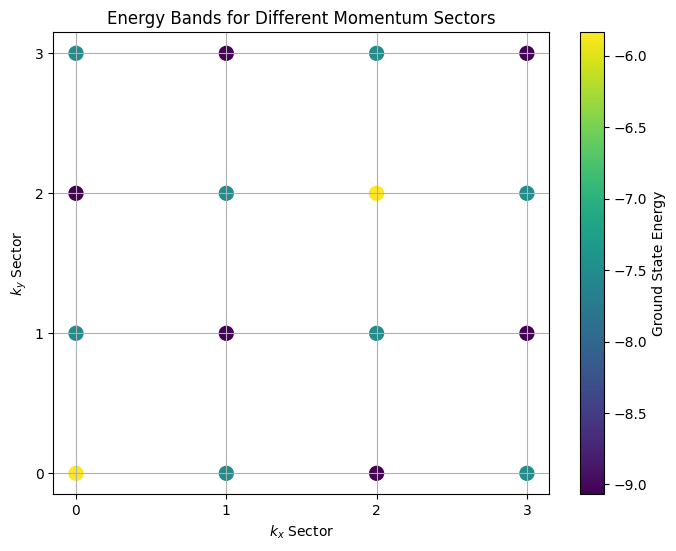

Total ground state is in  -9.069103240966797  and is in sector 3 1


In [11]:
kx_values = np.arange(Lx // q)  # Integer values for kx sectors
ky_values = np.arange(Ly)  # Integer values for ky sectors
energies = []

# Collect energies for the lowest band (index 0)
for kx in range(Lx // q):
    for ky in range(Ly):
        energies.append(energies_array[kx, ky, 0])  # Taking the lowest band (index 0)

# Plot the energy bands
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    np.repeat(kx_values, Ly),  # Repeat kx_values for each ky
    np.tile(ky_values, Lx // q),  # Tile ky_values for each kx
    c=energies, cmap='viridis', s=100
)
plt.colorbar(sc, label='Ground State Energy')
plt.title('Energy Bands for Different Momentum Sectors')
plt.xlabel('$k_x$ Sector')
plt.ylabel('$k_y$ Sector')
plt.xticks(range(Lx // q))
plt.yticks(range(Ly))
plt.grid(True)
plt.show()

# Find the minimum energy and its corresponding sector
min_energy = min(energies)
min_index = energies.index(min_energy)
kx_min = min_index // Ly  # Integer division to get kx index
ky_min = min_index % Ly  # Modulo to get ky index
print("Total ground state is in ", min_energy, " and is in sector", kx_min, ky_min)

The 1-th excited state has energy -9.069096 and is in sector (kx, ky) = (2, 0)
Quantum Ground State Energy: -9.069096
The ground state is NOT degenerate.
Calculating densities using hamiltonian.expt_value()...


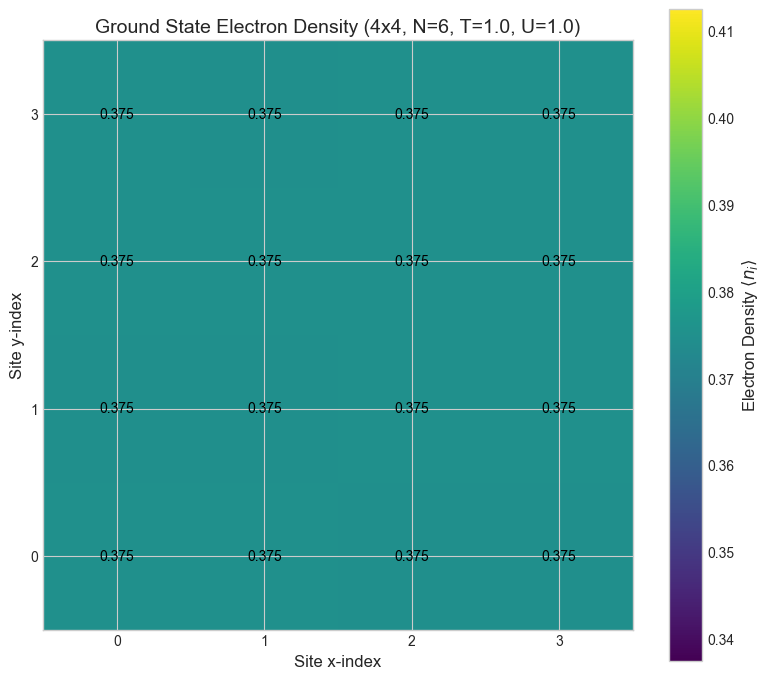

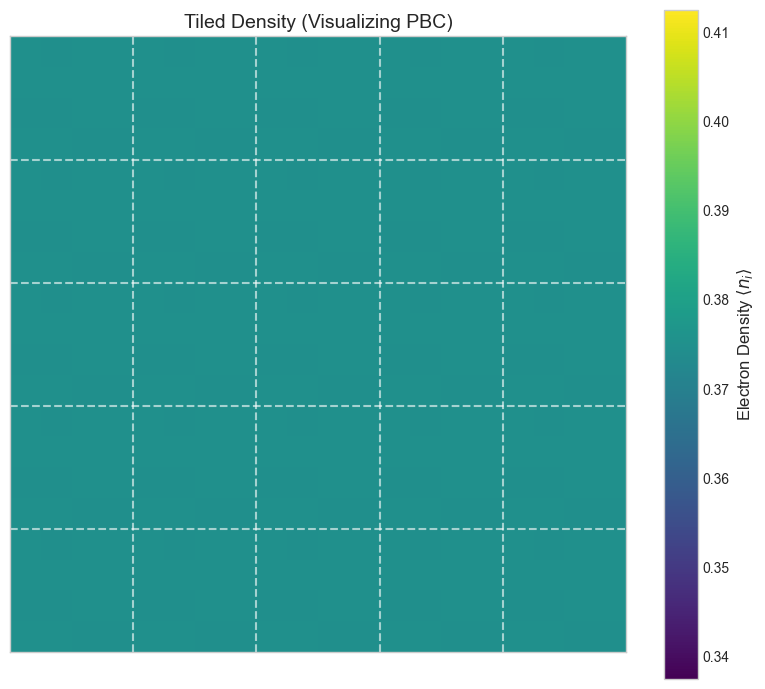

In [12]:
n=1  # Change this value to get different excited states

nth_excited_state = sorted_energies[n]  # This is a tuple (energy, kx, ky)
# Extract the energy and corresponding kx, ky sector
nth_energy, nth_kx, nth_ky, _ = nth_excited_state
# Print the result
print(f"The {n}-th excited state has energy {nth_energy:.6f} and is in sector (kx, ky) = ({nth_kx}, {nth_ky})")
plot_ground_state_density(sorted_energy_values[n:], sorted_ground_states[:, n:] , Lx, Ly, Nf, t, V, basis_full=basis_full)

Plotting the energy bands...


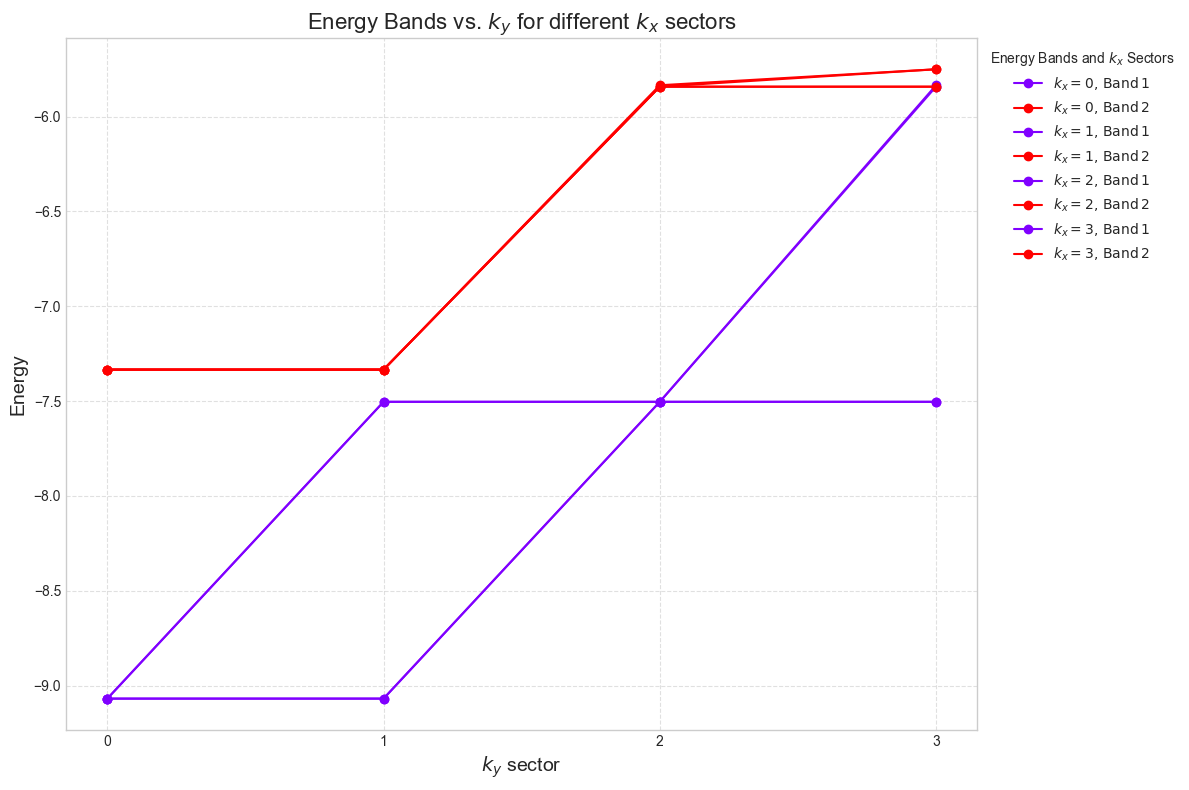

In [13]:
plot_energy_bands(energies_array, Lx, Ly, q)

In [14]:

Lx=4 # Total number of sites
Ly=4
Nf = 7 #N_sites // 2 # Number of fermions (half-filling)
N_sites = Lx * Ly
p=1
q=4
bands_number=2
t = 1.0      # Hopping strength
V = 1.0      # Interaction strength
V_min = 0.0
V_max = 5.0
num_V_points = 10
bands_number = 13
basis_full = spinless_fermion_basis_general(N_sites, Nf=Nf)
lowest_eigenvalues_by_V = get_lowest_eigenvalues_vs_V(Lx, Ly, Nf, t, p, q, basis_full=basis_full, V_min=V_min, V_max=V_max, num_V_points=num_V_points, bands_number=bands_number , across_all_sectors=True)

Building basis for 4x4 spinless fermion lattice (N=7)
Using translation by q=4 in x-direction.
Sectors: ky = 0, kx_prime = 0


Total Hilbert space size (no symmetries): 65536
Reduced basis size (with symmetries): 2860
Hilbert space size for 4x4 lattice and Nf=7 fermions: 2860 states
Particle conservation check passed!
Hamiltonian built

Finding ground state using Lanczos method...

Ground state energy for 2D system: [-11.313723  -11.313745  -11.313763  -11.313739  -11.3137665  -8.485314
 -11.313732   -8.485317  -11.313732   -8.485311  -11.313734  -11.313721
 -11.313709 ]
Building basis for 4x4 spinless fermion lattice (N=7)
Using translation by q=4 in x-direction.
Sectors: ky = 1, kx_prime = 0


Total Hilbert space size (no symmetries): 65536
Reduced basis size (with symmetries): 2860
Hilbert space size for 4x4 lattice and Nf=7 fermions: 2860 states
Particle conservation check passed!
Hamiltonian built

Finding ground state using Lanczos method...

Ground state energy for 2D system: [-

/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_60750/3884558836.py:8: GeneralBasisWarning: identity mapping found in set of transformations.
  basis= build_fermion_basis_with_translations(Lx, Ly, q, kx_sector, ky_sector, Nf)


Hamiltonian built

Finding ground state using Lanczos method...

Ground state energy for 2D system: [-9.259368 -9.259254 -8.817845 -8.817174 -8.815081 -8.815848 -8.418637
 -8.416661 -8.410104 -8.603766 -8.610077 -8.621041 -8.620603]
Building basis for 4x4 spinless fermion lattice (N=7)
Using translation by q=4 in x-direction.
Sectors: ky = 1, kx_prime = 0


Total Hilbert space size (no symmetries): 65536
Reduced basis size (with symmetries): 2860
Hilbert space size for 4x4 lattice and Nf=7 fermions: 2860 states
Particle conservation check passed!
Hamiltonian built

Finding ground state using Lanczos method...

Ground state energy for 2D system: [-9.259354  -9.259295  -8.418626  -8.4166565 -8.410105  -8.815057
 -8.815849  -8.817826  -8.817157  -8.603763  -8.610093  -8.621046
 -8.620589 ]
Building basis for 4x4 spinless fermion lattice (N=7)
Using translation by q=4 in x-direction.
Sectors: ky = 2, kx_prime = 0


Total Hilbert space size (no symmetries): 65536
Reduced basis size (with sy

Plotting the lowest eigenvalues vs. V...


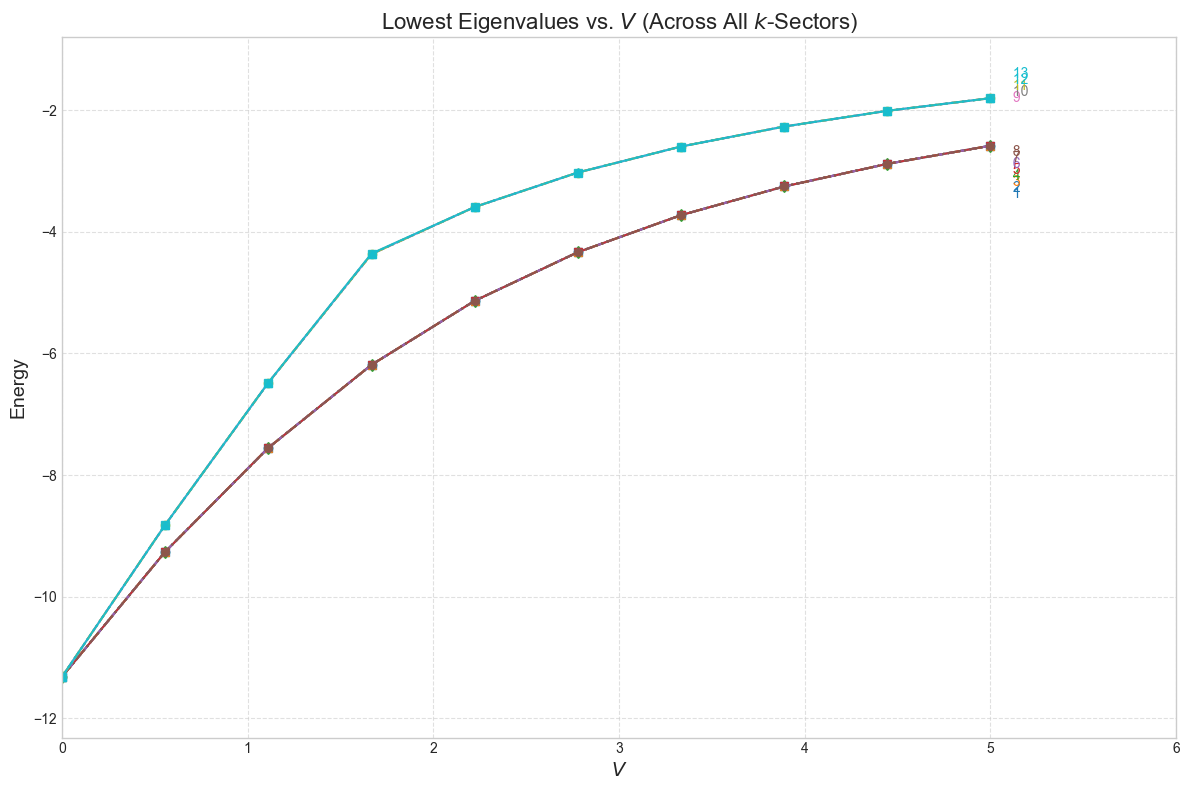

In [15]:
plot_lowest_eigenvalues_vs_V(lowest_eigenvalues_by_V, bands_number=bands_number)